# WDSR

In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

from data import DIV2K
from model.wdsr import wdsr_b, wdsr_a
from train import WdsrTrainer

%matplotlib inline

In [2]:
def show_current_time():
    current_time = datetime.now().strftime("%D %H:%M:%S")
    print(current_time)

In [3]:
# activate GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')

        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

# Model type
model_type = 'b'

# Model
wdsr_model = wdsr_b

In [5]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-{model_type}-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [6]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [7]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [8]:
trainer = WdsrTrainer(model=wdsr_model(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-{model_type}-{depth}-x{scale}')

In [9]:
show_current_time()

01/15/21 11:38:20


In [10]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=100000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/100000: loss = 9.751, PSNR = 27.941763 (150.26s)
2000/100000: loss = 7.383, PSNR = 28.336691 (156.07s)
3000/100000: loss = 7.030, PSNR = 28.497990 (149.93s)
4000/100000: loss = 6.928, PSNR = 28.595875 (146.79s)
5000/100000: loss = 6.968, PSNR = 28.683634 (149.11s)
6000/100000: loss = 6.823, PSNR = 28.773325 (148.86s)
7000/100000: loss = 6.864, PSNR = 28.833746 (145.88s)
8000/100000: loss = 6.843, PSNR = 28.861414 (146.61s)
9000/100000: loss = 6.777, PSNR = 28.912319 (145.63s)
10000/100000: loss = 6.750, PSNR = 28.854279 (145.76s)
11000/100000: loss = 6.703, PSNR = 28.917414 (145.46s)
12000/100000: loss = 6.705, PSNR = 28.968372 (145.28s)
13000/100000: loss = 6.726, PSNR = 28.936722 (145.41s)
14000/100000: loss = 6.698, PSNR = 28.938023 (145.75s)
15000/100000: loss = 6.651, PSNR = 28.994991 (145.34s)
16000/100000: loss = 6.685, PSNR = 29.001825 (145.18s)
17000/100000: loss = 6.565, PSNR = 28.938745 (145.40s)
18000/100000: loss = 6.643, PSNR = 29.003225 (145.51s)
19000/100000: loss 

In [11]:
show_current_time()

01/15/21 15:41:36


In [12]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 85000.


In [13]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 28.548471


In [14]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [15]:
model = wdsr_model(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [16]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

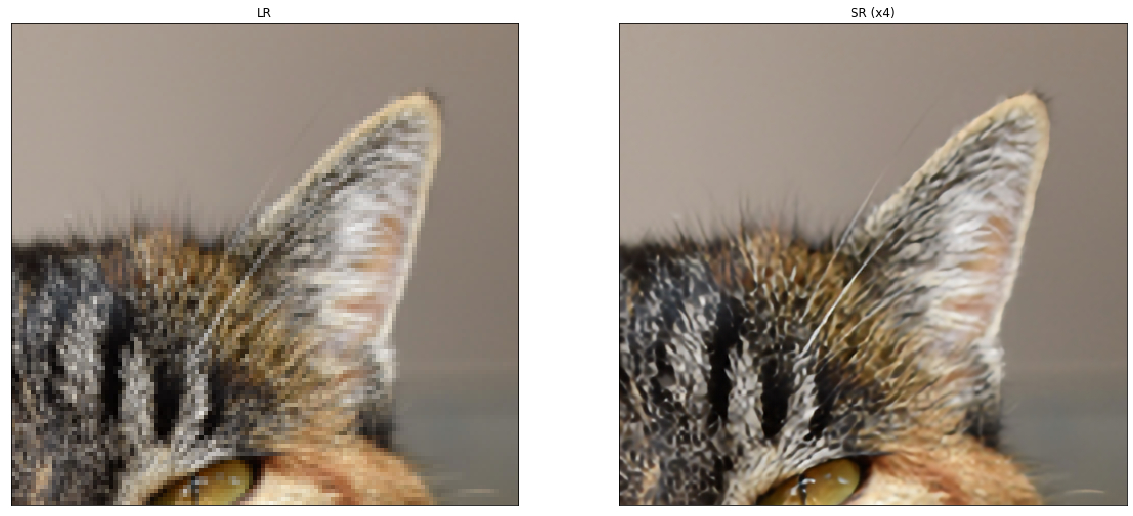

In [17]:
resolve_and_plot('demo/0869x4-crop.png')

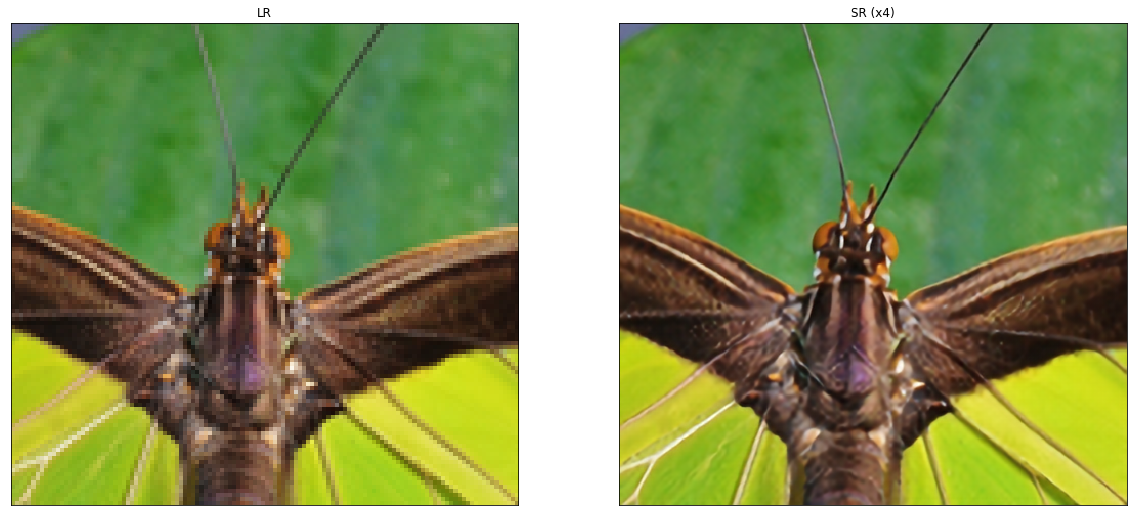

In [18]:
resolve_and_plot('demo/0829x4-crop.png')

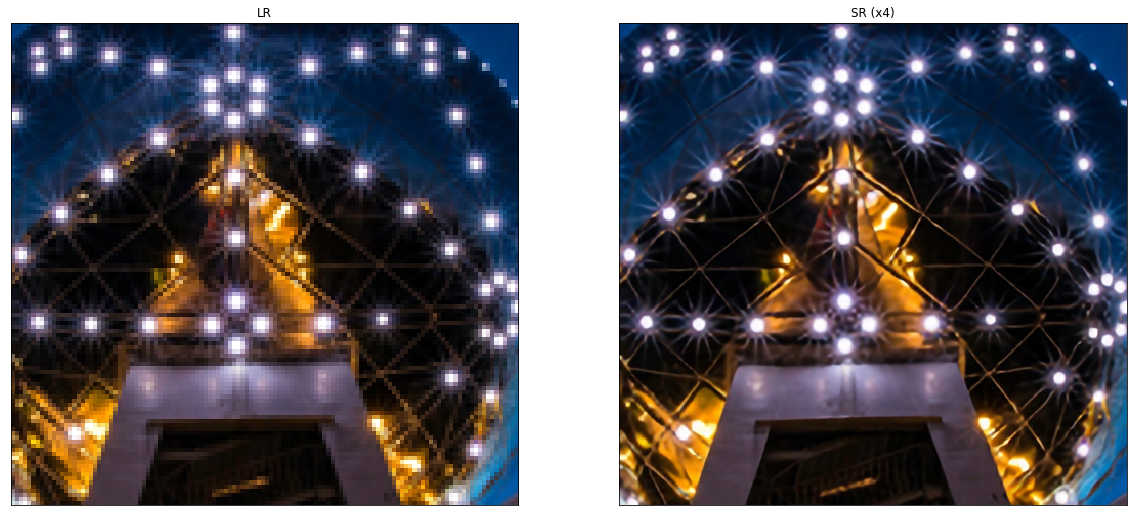

In [19]:
resolve_and_plot('demo/0851x4-crop.png')

In [22]:
weights_dir_a = f'weights/wdsr-a-{32}-x{scale}'
weights_file_a = os.path.join(weights_dir_a, 'weights.h5')

model_a = wdsr_a(scale=scale, num_res_blocks=32)
model_a.load_weights(weights_file_a)



weights_dir_b = f'weights/wdsr-b-{32}-x{scale}'
weights_file_b = os.path.join(weights_dir_b, 'weights.h5')

model_b = wdsr_b(scale=scale, num_res_blocks=32)
model_b.load_weights(weights_file_b)



weights_dir_b_16 = f'weights/wdsr-b-{16}-x{scale}'
weights_file_b_16 = os.path.join(weights_dir_b_16, 'weights.h5')

model_b_16 = wdsr_b(scale=scale, num_res_blocks=16)
model_b_16.load_weights(weights_file_b_16)


def resolve_and_plot(model, lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

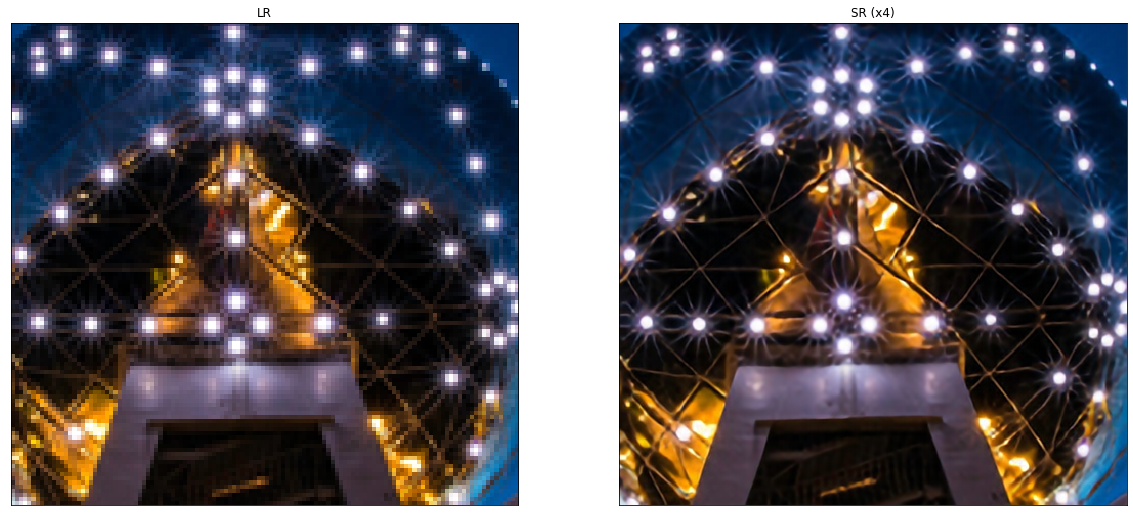

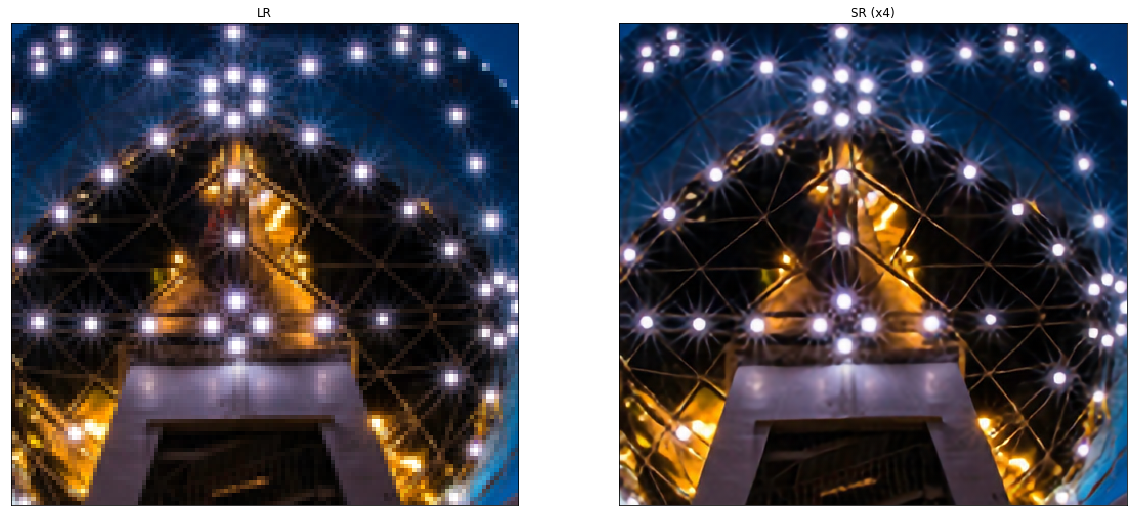

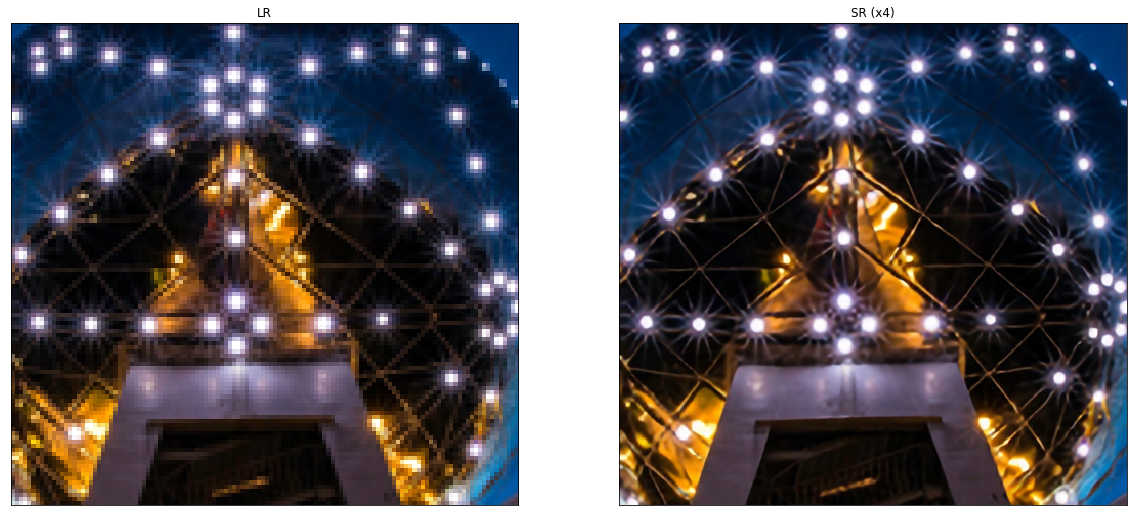

In [25]:
resolve_and_plot(model_a, 'demo/0851x4-crop.png')
resolve_and_plot(model_b, 'demo/0851x4-crop.png')
resolve_and_plot(model_b_16, 'demo/0851x4-crop.png')